<img src="https://www.th-ab.de/typo3conf/ext/th_ab/Resources/Public/assets/logo-th-ab.svg" alt="TH-AB Logo" width="200"/>

Prof. Dr. Möckel, Prof. Dr. Radke, Katharina Kuhnert

Maschinelles Lernen Schwerpunkt Data Science<br>
SoSe 2024

Source: https://www.datatechnotes.com/2024/04/introduction-to-recurrent-neural.html

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

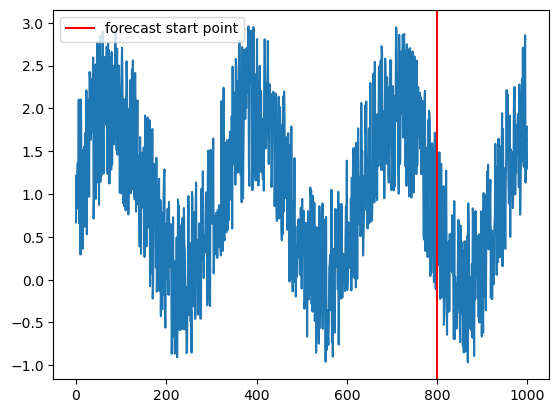

In [2]:
# Define parameters
step_size = 3
N = 1000
forecast_start = 800

# Generate data
t = np.arange(0, N)
x = np.sin(0.02*t) + 2*np.random.rand(N)
df = pd.DataFrame(x)

# Plot data
plt.plot(df)
plt.axvline(df.index[forecast_start], c="r", label="forecast start point")
plt.legend()
plt.show()

In [3]:
# Convert data into sequence and label with given length
def create_labels(data, step):
    X, y = [], []
    for i in range(len(data)-step):
        d = i + step
        X.append(data[i:d])
        y.append(data[d])
    return np.array(X), np.array(y)

In [4]:
# Prepare data for training and testing
values = df.values
train, test = values[:forecast_start,:], values[forecast_start:N,:]

# generate sequence data
trainX, trainY = create_labels(train, step_size)
testX, testY = create_labels(test, step_size)

# Reshape data for RNN input
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Convert data to PyTorch tensors
trainX_tens = torch.tensor(trainX, dtype=torch.float32)
trainY_tens = torch.tensor(trainY, dtype=torch.float32)
testX_tens = torch.tensor(testX, dtype=torch.float32)
testY_tens = torch.tensor(testY, dtype=torch.float32)
 
# Create DataLoader for training
train_dataset = torch.utils.data.TensorDataset(trainX_tens, trainY_tens)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

In [5]:
# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

In [6]:
# Hyperparameters
input_size = step_size
hidden_size = 128
output_size = 1
epochs = 100
learning_rate = 0.0001
 
# Instantiate RNN model
model = SimpleRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Train the model
for epoch in range(epochs):
    model.train()
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad() # Clears the gradients of all optimized parameters.
        output = model(batch_X)
        
        # Computes the loss between the model predictions and the ground 
        # truth labels for the current mini-batch.
        loss = criterion(output, batch_Y)
        
        # Computes gradients of the loss with respect to model parameters.
        loss.backward()
        
        # Updates model parameters based on the computed gradients using 
        # the specified optimization algorithm.
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.5816
Epoch [20/100], Loss: 0.5698
Epoch [30/100], Loss: 0.5868
Epoch [40/100], Loss: 0.5961
Epoch [50/100], Loss: 0.6041
Epoch [60/100], Loss: 0.6106
Epoch [70/100], Loss: 0.6156
Epoch [80/100], Loss: 0.6192
Epoch [90/100], Loss: 0.6217
Epoch [100/100], Loss: 0.6234


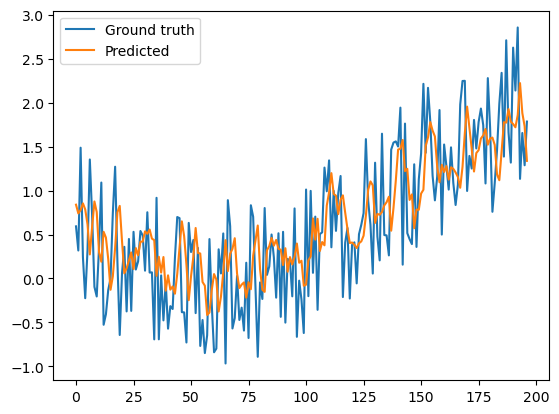

In [8]:
# Evaluation
with torch.no_grad():
    model.eval()
    testPredict = model(testX_tens)

# Plot results
index = range(len(testY))
plt.plot(index, testY, label="Ground truth")
plt.plot(index, testPredict.numpy(), label="Predicted")
plt.legend()
plt.show()